In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 데이터셋 압축풀기
# 이하 데이터 경로 전부 바꿔주기

%cd /content/drive/MyDrive
#!unzip -qq data.zip
#!unzip -qq train.zip
#!unzip -qq test.zip

/content/drive/MyDrive


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 사용 패키지

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# 데이터 살펴보기

In [5]:
sample = glob('/content/drive/MyDrive/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [6]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-10-07 09:10:00,25.9,26.6,25.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-10-07 09:00:00,25.0,25.4,24.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-10-07 08:50:00,23.9,24.6,23.2,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-10-07 08:40:00,22.6,23.1,22.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-10-07 08:30:00,21.2,22.1,20.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-10-05 09:00:00,26.3,26.9,25.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
290,2021-10-05 08:50:00,24.3,25.1,23.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
291,2021-10-05 08:40:00,23.3,23.7,23.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
292,2021-10-05 08:30:00,22.8,23.0,22.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


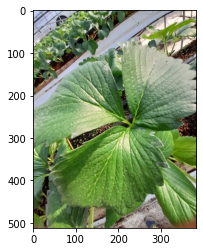

In [7]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# json
sample_json

{'annotations': {'area': 3,
  'bbox': [{'h': 212.14612055759804,
    'w': 285.5400773590686,
    'x': 36.96275658700981,
    'y': 271.6112706801471}],
  'crop': 1,
  'disease': '00',
  'grow': 12,
  'part': [],
  'risk': 0},
 'description': {'date': '20211007',
  'height': 512,
  'image': '11648.jpg',
  'region': 0,
  'task': 0,
  'time': '0914',
  'width': 384}}

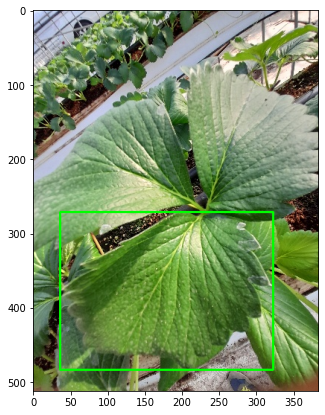

In [9]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [ ]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('/content/drive/MyDrive/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

  0%|          | 1/5766 [00:00<32:34,  2.95it/s]

## CustomDataset 제작

In [ ]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [ ]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

In [ ]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [ ]:
device = torch.device("cuda:0")
batch_size = 32
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 10
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [ ]:
train = sorted(glob('/content/drive/MyDrive/train/*'))
test = sorted(glob('/content/drive/MyDrive/test/*'))

labelsss = pd.read_csv('/content/drive/MyDrive/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [ ]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

# 모델

## 이미지 분류 모델 : Resnet50

In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

# 학습

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

In [ ]:
# GPU에 올라가있는 tensor cpu로 옮기기
# grad_fn항 제거

lp = []
vlp = []
for i in loss_plot:
  lp.append(i.cpu().detach())
for j in val_loss_plot:
  vlp.append(j.cpu())

#lp = lp.detach().numpy()

In [ ]:
print(lp)
print(vlp)
print(loss_plot)
print(val_loss_plot)

# 학습 결과

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(lp, label='train_loss')
plt.plot(vlp, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

# 추론

In [ ]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)

In [ ]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission['label'] = preds
submission

In [ ]:
submission.to_csv('baseline_submission.csv', index=False)